In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch 
import pyro
import pickle as pkl
from fitting.high_level import RegressionModel
from fitting.regression import DataValues
from fitting.high_level import makeDiagnosticPlots
import gpytorch
import matplotlib.pyplot as plt
from fitting.utils import affineTransformMVN
import pyro 
from fitting.high_level import RegressionModel
from fitting.regression import DataValues, makeRegressionData
from fitting.utils import getScaledEigenvecs, fixMVN, affineTransformMVN
from fitting.transformations import getNormalizationTransform
import fitting.models as models
import fitting.regression as regression
import fitting.transformations as transformations
import fitting.windowing as windowing
from gpytorch.kernels import ScaleKernel as SK
import hist
import tqdm



import pyro.distributions as pyrod
import pyro.infer as pyroi


from fitting.plot_tools import createSlices, getPolyFromSquares, makeSquares, simpleGrid


In [3]:
with open(
    "regression_results/2018_Control_nn_uncomp_0p67_m14_vs_mChiUncompRatio.pkl",
    "rb",
) as f:
    control = pkl.load(f)

inhist = control["Data2018", "Control"]["hist_collection"]["histogram"]#[hist.loc(1000) :, hist.loc(0) :]


In [4]:
class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self):
        super(LargeFeatureExtractor, self).__init__()
        self.add_module('linear1', torch.nn.Linear(2, 32))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(32, 16))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(16, 8))
        self.add_module('relu3', torch.nn.ReLU())
        self.add_module('linear4', torch.nn.Linear(8, 2))

ft = LargeFeatureExtractor()
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2))

            self.feature_extractor = ft
            self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

        def forward(self, x):
            projected_x = self.feature_extractor(x)
            projected_x = self.scale_to_bounds(projected_x)
            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
class RBFLayer(torch.nn.Module):
    def __init__(self, dim, count):
        super().__init__()
        self.length_scales = torch.nn.Parameter(torch.ones(count))
        self.centers = torch.nn.Parameter(torch.ones(count,dim))

    def forward(self, vals):
        return torch.exp((torch.unsqueeze(vals,1) - self.centers).pow(2).sum(-1)/(2 * self.length_scales))

r = RBFLayer(2,3)       
a = torch.tensor([[0.9041,  0.0196], [-0.3108, -2.4423], [-0.4821,  1.059], [-0.4821,  1.059], [-0.4821,  1.059], [-0.4821,  1.059]])
l =  torch.nn.Linear(3,1)

l(r(a))

tensor([[  -1.6730],
        [-999.4132],
        [  -3.2343],
        [  -3.2343],
        [  -3.2343],
        [  -3.2343]], grad_fn=<AddmmBackward0>)

In [6]:
class NonStatKernel(gpytorch.kernels.RBFKernel):
    # the sinc kernel is stationary
    is_stationary = False
    def __init__(self, dim=2, count=4, **kwargs):
        super().__init__(**kwargs)
        self.pre_transform = RBFLayer(dim,count)
        self.trans = torch.nn.Linear(count,1)
        #self.add_module("trans", self.trans)
        #self.add_module("pre", self.pre_transform)

    # this is the kernel function
    def forward(self, x1, x2, diag=False, **params):

        v1 = self.trans(self.pre_transform(x1))
        v2 = self.trans(self.pre_transform(x2))
        r =  super().forward(x1,x2,diag=diag,**params)

        if diag:
            o = torch.squeeze(v1*v2) 
        else:
            o =torch.outer(v1.squeeze(), v2.squeeze())

        return o * r #, **params)
        
class NonStatGP(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood, function=None):
            super().__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()

            self.base_covar_module = NonStatKernel(ard_num_dims=2)  #* NonStatKernel(ard_num_dims=2)
            if False:
                self.covar_module = self.base_covar_module                                                   
            else:
                self.covar_module = gpytorch.kernels.InducingPointKernel(self.base_covar_module,
                            likelihood=likelihood,
                             inducing_points=train_x[::2].clone())

           # self.covar_module = SK(NonStatKernel(ard_num_dims=2))
        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [8]:
def randSample(*args, size=None):
    p = torch.randperm(args[0].size(0))
    return [x[p[:size]] for x in args]

def batchify(*args, size=None, batches=None):
    vals = [randSample(*args, size=size) for i in range(batches)]
    return tuple(torch.stack(x) for x in zip(*vals))


In [9]:
def chi2bins(obs,exp,var):
    return torch.sum((obs-exp).pow(2) / var ) / obs.size(0)

torch.Size([60, 60])


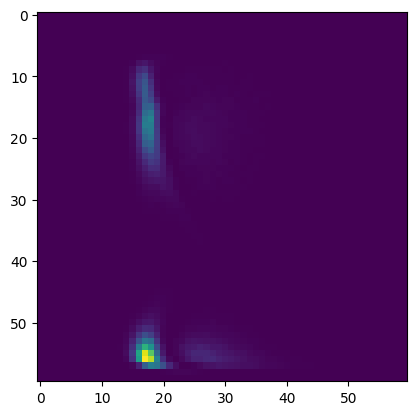

In [45]:
edges_x1 = torch.from_numpy(inhist.axes[0].edges)
edges_x2 = torch.from_numpy(inhist.axes[1].edges)

centers_x1 = torch.diff(edges_x1) / 2 + edges_x1[:-1]
centers_x2 = torch.diff(edges_x2) / 2 + edges_x2[:-1]
centers_x1.shape

bin_values = torch.from_numpy(inhist.values()).T
dx,dy =torch.gradient(bin_values,spacing=(centers_x1,centers_x2))
D = dx**2 + dy**2
print(g.shape)
fig,ax=plt.subplots()
ax.imshow(D)

In [29]:
from torch.utils.data import TensorDataset, DataLoader
def bumpCut(X, Y):
    m = Y > (1 - 200 / X)
    return m

window_func = windowing.EllipseWindow([1300,0.5],[160,0.06])
#window_func = windowing.EllipseWindow([0.5,0.5],[0.1,0.1])

min_counts = 50
train_data,*_ = regression.makeRegressionData(
    inhist, window_func, domain_mask_function=bumpCut, exclude_less=min_counts
)
test_data, domain_mask,reshape,*_ = regression.makeRegressionData(
    inhist,
    None,
    get_mask=True,
    domain_mask_function=bumpCut,
    exclude_less=min_counts,
    get_reshape_function=True,
)
train_transform = transformations.getNormalizationTransform(train_data)
normalized_train_data = train_transform.transform(train_data)
normalized_test_data = train_transform.transform(test_data)


LinearTransform(tensor([2.6500e+03, 9.0000e-01]), tensor([0., 0.]))
LinearTransform(tensor([5342.7125]), tensor([4047.3054]))


In [30]:
normalized_test_data.X
Y = normalized_test_data.Y
X = normalized_test_data.X
#torch.gradient(Y,X)
print(reshape(X))

RuntimeError: unflatten: Provided sizes [60, 60] don't multiply up to the size of dim 1 (2) in the input tensor

In [ ]:
kernel = SK(gpytorch.kernels.RBFKernel(ard_num_dims=2)) 

# kernel = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4,ard_num_dims=2)
#kernel = SK(gpytorch.kernels.MaternKernel(ard_num_dims=2)) * SK(gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=2))* SK(gpytorch.kernels.MaternKernel(nu=0.5, ard_num_dims=2))
use_cuda = True


if torch.cuda.is_available() and use_cuda:
    train = normalized_train_data.toGpu()
    norm_test = normalized_test_data.toGpu()
    print("USING CUDA")
else:
    train = normalized_train_data
    norm_test = normalized_test_data
    

#trainX, trainY, trainV = batchify(train.X,train.Y,train.V, size=800, batches=10)

trainX, trainY, trainV = train.X, train.Y, train.V

#kernel = SK(gpytorch.kernels.MaternKernel(ard_num_dims=2)) * SK(gpytorch.kernels.RBFKernel(ard_num_dims=2))
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(
    noise=trainV*4,
    learn_additional_noise=False,
)

#model = GPRegressionModel(trainX, trainY, likelihood)
#model = NonStatGP(normalized_train_data.X, normalized_train_data.Y, likelihood,)
model = models.ExactAnyKernelModel(trainX, trainY, likelihood, kernel=kernel)
print(model)
lr = 0.05
if torch.cuda.is_available() and use_cuda:
    model = model.cuda()
    likelihood = likelihood.cuda()

# if hasattr(model.covar_module, "initialize_from_data"):
#     model.covar_module.initialize_from_data(train.X, train.Y)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(400):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(trainX)
    # Calc loss and backprop gradients
    l = -mll(output, trainY)
    mse = gpytorch.metrics.mean_squared_error(output, trainY,  squared=True)
    #print(l)
    loss = l
    loss.backward()
    if i % 20 == 0 :     
        print('Iter %d/%d - Loss: %.3f' % (i + 1, 200, loss.item()))
    
    optimizer.step()

# model, likelihood, evidence = regression.optimizeHyperparams(
#     model,
#     likelihood,
#     train,
#     bar=False,
#     iterations=800,
#     lr=lr,
#     get_evidence=True,
# )
if torch.cuda.is_available() and use_cuda:
    model = model.cpu()
    likelihood = likelihood.cpu()

AttributeError: 'tuple' object has no attribute 'X'

In [ ]:
model.covar_module.base_kernel.lengthscale = torch.tensor([[0.1,0.1]])
model.covar_module.outputscale = torch.tensor(0.1)

In [ ]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.round(decimals=2).tolist()}')

In [ ]:
pred_dist = regression.getPrediction(
    model, likelihood, normalized_test_data
)
print(pred_dist)


with gpytorch.settings.cholesky_max_tries(30):
    psd_pred_dist = fixMVN(pred_dist)
pred_dist = type(pred_dist)(
    psd_pred_dist.mean, psd_pred_dist.covariance_matrix.to_dense()
)
slope = train_transform.transform_y.slope
intercept = train_transform.transform_y.intercept
pred_dist = affineTransformMVN(psd_pred_dist, slope, intercept)


to_use = test_data
to_use = regression.DataValues(
    to_use.X,#.unsqueeze(0).repeat(4,1,1),
    to_use.Y,#.unsqueeze(0).repeat(4,1),
    to_use.V,#.unsqueeze(0).repeat(4,1),
    to_use.E,
)



pred_data = regression.DataValues(
    to_use.X,
    pred_dist.mean,
    pred_dist.variance,
    to_use.E,
)

mask = regression.getBlindedMask(pred_data.X, pred_data.Y, to_use.Y, to_use.V, window_func)
print(mask)
#gbm = (slice(None),torch.ones_like( test_data.Y > 50))
gbm = torch.ones_like(test_data.Y > 50)

x =     torch.sum((pred_data.Y[gbm] - to_use.Y[gbm]) ** 2/ to_use.V[gbm], dim=0)
global_chi2_bins = torch.sum((pred_data.Y[gbm] - to_use.Y[gbm]) ** 2/ to_use.V[gbm], dim=0)/ to_use.Y[gbm].shape[0]

print(f"Global Chi2/bins = {global_chi2_bins}")
ok = True


mask = regression.getBlindedMask(
    pred_data.X, pred_data.Y, test_data.Y, test_data.V, window_func
)
wm= (slice(None), mask)
print(mask.shape)
bpred_mean = pred_data.Y[mask]
obs_mean = to_use.Y[mask]
obs_var = to_use.V[mask]
print(bpred_mean)
chi2 = torch.sum((obs_mean - bpred_mean) ** 2 / obs_var) / torch.count_nonzero(
    mask
)
avg_pull = torch.sum(
    torch.abs((obs_mean - bpred_mean)) / torch.sqrt(obs_var),dim=0
) / torch.count_nonzero(mask)

print(f"Avg Abs pull = {avg_pull}")
print(f"Chi^2/bins = {chi2}")

print(f"Global Chi2/bins = {global_chi2_bins}")


In [ ]:
if hasattr(model.covar_module, "inducing_points"):
    i = model.covar_module.inducing_points.detach().numpy()
else:
    i = None
plots = makeDiagnosticPlots(pred_data,
                            test_data, 
                            train_data,
                            mask,
                            inducing_points=i)

In [ ]:
fe = model.feature_extractor
#for param_name, param in model.named_parameters():
#    print(f'Parameter name: {param_name:42} value = {param.round(decimals=2).tolist()}')

s = model.scale_to_bounds
def t(x):
    return fe(x)

T = t(test_data.X).detach()
print(T[:,0] / T[:,1])
fig,ax=plt.subplots()
ax.scatter(T[:,0], T[:,1], c=test_data.Y, cmap='hsv')

In [ ]:
   logger.info("Done with loop")
            print("Done with loop")
            raw_pred_dist = regression.getPrediction(
                model, likelihood, normalized_test_data
            )
            with gpytorch.settings.cholesky_max_tries(30):
                psd_pred_dist = fit_utils.fixMVN(raw_pred_dist)
            raw_pred_dist = type(raw_pred_dist)(
                psd_pred_dist.mean, psd_pred_dist.covariance_matrix.to_dense()
            )
            slope = train_transform.transform_y.slope
            intercept = train_transform.transform_y.intercept
            pred_dist = fit_utils.affineTransformMVN(psd_pred_dist, slope, intercept)

            pred_data = regression.DataValues(
                test_data.X,
                pred_dist.mean,
                pred_dist.variance,
                test_data.E,
            )

            good_bin_mask = test_data.Y > 500
            global_chi2_bins = float(
                torch.sum(
                    (pred_data.Y[good_bin_mask] - test_data.Y[good_bin_mask]) ** 2
                    / test_data.V[good_bin_mask]
                )
                / test_data.Y[good_bin_mask].shape[0]
            )
            print(f"Global Chi2/bins = {global_chi2_bins}")
            if global_chi2_bins < 1.5:
                ok = True
            else:
                logger.warning("Bad global Chi2, retrying")
            ok = True

        except (
            linear_operator.utils.errors.NanError,
            linear_operator.utils.errors.NotPSDError,
        ) as e:
            lr = lr + random.random() / 1000
            logger.warning(f"CHOLESKY FAILED: retrying with lr={round(lr,3)}")
            logger.warning(e)

    logger.warning("Done training")

    data = {
        "evidence": evidence,
        "global_chi2/bins": global_chi2_bins,
        "model_string": str(model),
    }

    if window_func:
        mask = regression.getBlindedMask(
            pred_data.X, pred_data.Y, test_data.Y, test_data.V, window_func
        )
        bpred_mean = pred_data.Y[mask]
        obs_mean = test_data.Y[mask]
        obs_var = test_data.V[mask]
        chi2 = torch.sum((obs_mean - bpred_mean) ** 2 / obs_var) / torch.count_nonzero(
            mask
        )
        avg_pull = torch.sum(
            torch.abs((obs_mean - bpred_mean)) / torch.sqrt(obs_var)
        ) / torch.count_nonzero(mask)

        data.update(
            {
                "chi2_blinded": float(chi2),
                "avg_abs_pull": float(avg_pull),
            }
        )
        print(f"Avg Abs pull = {avg_pull}")
        print(f"Chi^2/bins = {chi2}")
    else:
        mask = None
    print(f"Global Chi2/bins = {global_chi2_bins}")

    save_dir = Path(save_dir)
    save_dir.mkdir(exist_ok=True, parents=True)
    if True:
        diagnostic_plots = makeDiagnosticPlots(pred_data, test_data, train_data, mask)
        saveDiagnosticPlots(diagnostic_plots, save_dir)
        # makeSlicePlots(pred_data, test_data, inhist, window_func, 0, save_dir)
        # makeSlicePlots(pred_data, test_data, inhist, window_func, 1, save_dir)

    model_dict = model.state_dict()

    save_data = RegressionModel(
        input_data=inhist,
        window=window_func,
        domain_mask=domain_mask,
        train_data=train_data,
        test_data=test_data,
        trained_model=model,
        raw_posterior_dist=raw_pred_dist,
        posterior_dist=pred_dist,
    )
    torch.save(save_data, save_dir / "train_model.pth")
    torch.save(save_data, save_dir / "model_dict.pth")
    torch.save(pred_dist, save_dir / "posterior_latent.pth")
    with open(save_dir / "info.json", "w") as f:
        json.dump(data, f)
    return save_data